In [ ]:
# For colab
!git clone https://github.com/theo-long/bayesopt_playground.git
!git clone https://github.com/automl/HPOBench.git
!cd HPOBench && pip install .[paramnet]
!pip install botorch

In [ ]:
!cd bayesopt_playground && git pull

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), 331 bytes | 331.00 KiB/s, done.
From https://github.com/theo-long/bayesopt_playground
   1126aae..3599b06  main       -> origin/main
Updating 1126aae..3599b06
Fast-forward
 models.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [ ]:
from botorch.models.gp_regression_fidelity import SingleTaskMultiFidelityGP
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize, Log10, ChainedInputTransform
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from botorch.optim.fit import fit_gpytorch_mll_torch

from bayesopt_playground import benchmarks, optimization_loops, models

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
objective, bounds = benchmarks.generate_optimization_task(benchmarks.paramnet_adult)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train_x, train_obj, train_cost, _ = optimization_loops.generate_initial_data(objective, bounds, n=30)
train_x = train_x.squeeze(1)
train_obj = train_obj.unsqueeze(-1)
train_cost  = train_cost.unsqueeze(-1)

test_x, test_obj, test_cost, _ = optimization_loops.generate_initial_data(objective, bounds, n=1024)
test_x = test_x.squeeze(1)
test_obj = test_obj.unsqueeze(-1)
test_cost  = test_cost.unsqueeze(-1)

In [ ]:
from gpytorch.kernels import CosineKernel

In [ ]:
target = 'cost'

if target == 'cost':
  train_target = train_cost
  test_target = test_cost
else:
  train_target = train_obj
  test_target = test_obj

iteration_model = SingleTaskMultiFidelityGP(
    train_x,
    train_target,
    iteration_fidelity=-1,
    linear_truncated=False,
    input_transform=Normalize(d=train_x.shape[-1], bounds=bounds),
    outcome_transform=Standardize(m=1)
)
iteration_mll = ExactMarginalLogLikelihood(iteration_model.likelihood, iteration_model)
fit_gpytorch_mll(iteration_mll)

fidelity_model = SingleTaskMultiFidelityGP(
    train_x,
    train_target,
    data_fidelity=-1,
    linear_truncated=False,
    input_transform=Normalize(d=train_x.shape[-1], bounds=bounds),
    outcome_transform=Standardize(m=1)
)


fidelity_mll = ExactMarginalLogLikelihood(fidelity_model.likelihood, fidelity_model)
_ = fit_gpytorch_mll(fidelity_mll)

linear_truncated_model = SingleTaskMultiFidelityGP(
    train_x,
    train_target,
    data_fidelity=-1,
    linear_truncated=True,
    input_transform=Normalize(d=train_x.shape[-1], bounds=bounds),
    outcome_transform=Standardize(m=1)
)

linear_truncated_mll = ExactMarginalLogLikelihood(linear_truncated_model.likelihood, linear_truncated_model)
_ = fit_gpytorch_mll(linear_truncated_mll)

mat_iteration_model = models.CustomSingleTaskMultiFidelityGP(
    train_x,
    train_target,
    iteration_fidelity=-1,
    linear_truncated=False,
    input_transform=Normalize(d=train_x.shape[-1], bounds=bounds),
    outcome_transform=Standardize(m=1),
    kernel = models.MaternKernel
)
mat_iteration_mll = ExactMarginalLogLikelihood(mat_iteration_model.likelihood, mat_iteration_model)
fit_gpytorch_mll(mat_iteration_mll)

mat_fidelity_model = models.CustomSingleTaskMultiFidelityGP(
    train_x,
    train_target,
    data_fidelity=-1,
    linear_truncated=False,
    input_transform=Normalize(d=train_x.shape[-1], bounds=bounds),
    outcome_transform=Standardize(m=1),
    kernel = models.MaternKernel
)


mat_fidelity_mll = ExactMarginalLogLikelihood(mat_fidelity_model.likelihood, mat_fidelity_model)
_ = fit_gpytorch_mll(mat_fidelity_mll)

from botorch.models.cost import AffineFidelityCostModel
basic_cost_model = AffineFidelityCostModel(fixed_cost=-0.5)

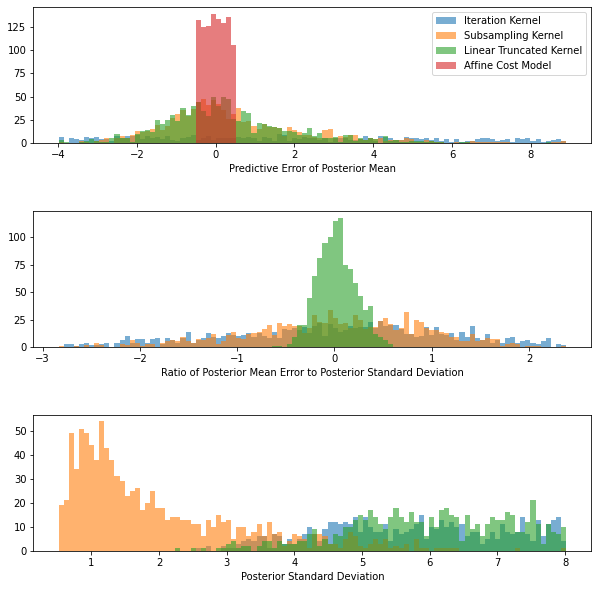

In [ ]:
plot_models = [iteration_model, fidelity_model, linear_truncated_model, basic_cost_model]
labels = ["Iteration Kernel", "Subsampling Kernel", "Linear Truncated Kernel", "Affine Cost Model"]

fig, ax = plt.subplots(3, figsize=(10,10))
fig.subplots_adjust(hspace=0.5)
ax[0].set_xlabel("Predictive Error of Posterior Mean")
ax[1].set_xlabel("Ratio of Posterior Mean Error to Posterior Standard Deviation")
ax[2].set_xlabel("Posterior Standard Deviation")

posterior = plot_models[1].posterior(test_x)
preds = posterior.mean
errors = (preds - test_target).detach().numpy().flatten()
std_devs = np.sqrt(posterior.variance.detach().numpy()).flatten()
bins = np.histogram(errors, bins=100)[1]
bins2 = np.histogram((errors / std_devs), bins=100)[1]
bins3 = np.histogram(std_devs, bins=100)[1]

for model, label in zip(plot_models, labels):
  if isinstance(model, AffineFidelityCostModel):
    preds = model(test_x)
    errors = (preds - test_target).detach().numpy().flatten()
    ax[0].hist(errors, bins, alpha=0.6, label=label)
  else:
    posterior = model.posterior(test_x)
    preds = posterior.mean
    errors = (preds - test_target).detach().numpy().flatten()
    std_devs = np.sqrt(posterior.variance.detach().numpy()).flatten()
    ax[0].hist(errors, bins, alpha=0.6, label=label)
    ax[1].hist((errors / std_devs), bins2, alpha=0.6)
    ax[2].hist(std_devs, bins3, alpha=0.6)

ax[0].legend()

if target == 'cost':
  pass
else:
  ax[0].set_xlim(-0.1, 0.1)
  ax[1].set_xlim(-5.0, 5.0)

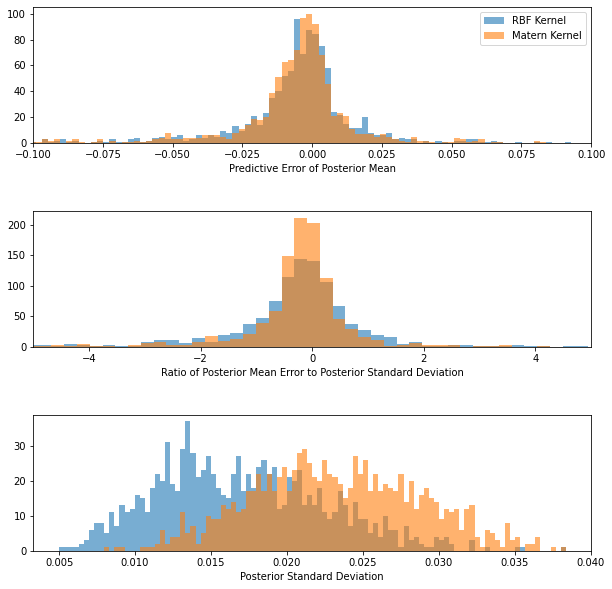

In [ ]:
plot_models = [iteration_model, mat_iteration_model]
labels = ["RBF Kernel", "Matern Kernel"]

fig, ax = plt.subplots(3, figsize=(10,10))
fig.subplots_adjust(hspace=0.5)
ax[0].set_xlabel("Predictive Error of Posterior Mean")
ax[1].set_xlabel("Ratio of Posterior Mean Error to Posterior Standard Deviation")
ax[2].set_xlabel("Posterior Standard Deviation")

posterior = plot_models[0].posterior(test_x)
preds = posterior.mean
errors = (preds - test_target).detach().numpy().flatten()
std_devs = np.sqrt(posterior.variance.detach().numpy()).flatten()
bins = np.histogram(errors, bins=100)[1]
bins2 = np.histogram((errors / std_devs), bins=100)[1]
bins3 = np.histogram(std_devs, bins=100)[1]

for model, label in zip(plot_models, labels):
  if isinstance(model, AffineFidelityCostModel):
    preds = model(test_x)
    errors = (preds - test_target).detach().numpy().flatten()
    ax[0].hist(errors, bins, alpha=0.6, label=label)
  else:
    posterior = model.posterior(test_x)
    preds = posterior.mean
    errors = (preds - test_target).detach().numpy().flatten()
    std_devs = np.sqrt(posterior.variance.detach().numpy()).flatten()
    ax[0].hist(errors, bins, alpha=0.6, label=label)
    ax[1].hist((errors / std_devs), bins2, alpha=0.6)
    ax[2].hist(std_devs, bins3, alpha=0.6)

ax[0].legend()

if target == 'cost':
  pass
else:
  ax[0].set_xlim(-0.1, 0.1)
  ax[1].set_xlim(-5.0, 5.0)